/home/mila/e/eric.elmoznino/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
1it [01:47, 107.85s/it]
/home/mila/e/eric.elmoznino/.conda/envs/pytorch/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:3285: RuntimeWarning: divide by zero encountered in log
  return log(self._pmf(k, *args))
2it [00:00,  8.70it/s, Epoch 0 - Train:0.3647, Val:0.3914]
2it [00:00,  2.99it/s, Epoch 1 - Train:0.3649, Val:0.3619]
2it [00:00,  3.48it/s, Epoch 2 - Train:0.3333, Val:0.2379]
2it [00:00,  3.48it/s, Epoch 3 - Train:0.2115, Val:0.1840]
2it [00:00,  3.48it/s, Epoch 4 - Train:0.1471, Val:0.1430]
2it [00:00,  3.48it/s, Epoch 5 - Train:0.1121, Val

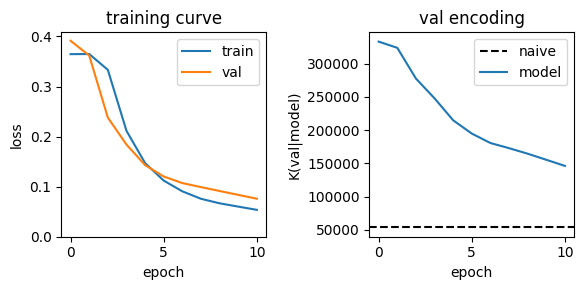

In [2]:
import sys
sys.path.append("../")
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.skellam import approx_gaussian_logpmf

from transformers import AutoModel
from sentence_transformers import SentenceTransformer

data_dir = "/home/mila/e/eric.elmoznino/scratch/complexity_compositionality/data/real_languages/coco-captions/"

epochs = 10
batch_size = 256
lr = 1e-4
val_ratio = 0.2
pretrained_embeddings = True
pretrained_model = False
max_data = 10000000

if pretrained_model:
    assert pretrained_embeddings
    w = torch.load(data_dir + "w.pt")
else:
    if pretrained_embeddings:
        w = torch.load(data_dir + "w.pt")
    else:
        w = torch.load(data_dir + "w_short.pt")
z = torch.load(data_dir + "z.pt")
data_size = min(len(z), max_data)
num_train = int((1 - val_ratio) * data_size)
num_val = data_size - num_train
w_train, z_train = w[:num_train], z[:num_train]
w_val, z_val = w[-num_val:], z[-num_val:]
z_marginal_mu = z_val.mean(dim=0, keepdim=True).to("cuda")
z_marginal_std = z_val.std(dim=0, keepdim=True).to("cuda")

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
if not pretrained_model:
    config = model[0].auto_model.config
    if pretrained_embeddings:
        rand_state = AutoModel.from_config(config).state_dict()
        rand_state = {k: v for k, v in rand_state.items() if "embeddings" not in k}
        incompatible = model[0].auto_model.load_state_dict(
            rand_state, strict=False
        )
        assert (len(incompatible.missing_keys) > 0 and 
                all(["embeddings" in k for k in incompatible.missing_keys]))
    else:
        config.vocab_size = 14722
        model[0].auto_model = AutoModel.from_config(config)
model.to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def model_forward(model, w_batch, z_batch):
    attention_mask = torch.ones_like(w_batch)
    attention_mask[w_batch == 1] = 0  # Assumes 1 is the padding token
    w_batch = {"input_ids": w_batch, "attention_mask": attention_mask}
    z_pred = model.forward(w_batch)["sentence_embedding"]
    loss = F.mse_loss(z_pred, z_batch)
    return loss, z_pred

train_losses = []
val_losses = []
val_encodings = []

for epoch in range(0, epochs + 1):
    pbar = tqdm(range(data_size // batch_size))
    
    model.train()
    train_loss = 0.0
    for i in range(0, num_train, batch_size):
        w_batch, z_batch = w_train[i:i+batch_size].to("cuda"), z_train[i:i+batch_size].to("cuda")
        if epoch > 0:
            loss_batch, _ = model_forward(model, w_batch, z_batch) 
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        else:   # Initial training set loss, prior to start of training
            with torch.no_grad():
                loss_batch, _ = model_forward(model, w_batch, z_batch) 
        train_loss += loss_batch.cpu().item() * len(w_batch) / num_train
        pbar.update()
    train_losses.append(train_loss)
        
    model.eval()
    val_loss = 0.0
    val_encoding = 0.0
    for i in range(0, num_val, batch_size):
        w_batch, z_batch = w_val[i:i+batch_size].to("cuda"), z_val[i:i+batch_size].to("cuda")
        with torch.no_grad():
            loss_batch, z_mu = model_forward(model, w_batch, z_batch) 
        val_loss += loss_batch.cpu().item() * len(w_batch) / num_val
        neg_logp = -approx_gaussian_logpmf(z_batch, z_mu, z_marginal_std.expand_as(z_mu))
        naive_neg_logp = -approx_gaussian_logpmf(z_batch, z_marginal_mu.expand_as(z_batch), z_marginal_std.expand_as(z_batch))
        neg_logp = torch.where(torch.isinf(neg_logp), naive_neg_logp, neg_logp)
        val_encoding += neg_logp.sum().cpu().item()
        pbar.update()
    val_losses.append(val_loss)
    val_encodings.append(val_encoding)
    
    pbar.set_postfix_str(f"Epoch {epoch} - Train:{train_loss:.4f}, Val:{val_loss:.4f}")
    pbar.close()

naive_logp = approx_gaussian_logpmf(z_val, z_marginal_mu.cpu(), z_marginal_std.cpu())
naive_val_encoding = -naive_logp.sum().item()
    
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs[0].plot(range(len(train_losses)), train_losses, label="train")
axs[0].plot(range(len(val_losses)), val_losses, label="val")
axs[0].set(xlabel="epoch", ylabel="loss", title="training curve", ylim=(0, None))
axs[0].legend()

axs[1].axhline(y=naive_val_encoding, color="black", linestyle="--", label="naive")
axs[1].plot(range(len(val_encodings)), val_encodings, label="model")
axs[1].set(xlabel="epoch", ylabel="K(val|model)", title="val encoding")
axs[1].legend()

fig.tight_layout()
fig.savefig(f"train_full_natural_languages | pretrained={pretrained_model}, pretrained_embeddings={pretrained_embeddings}, data_size={data_size}.pdf")
plt.show()

In [3]:
F.mse_loss(z_marginal_mu.expand_as(z_val).cpu(), z_val).item(), val_losses[-1]

(0.008606242947280407, 0.07588771730661392)

### Test to see if our chosen Skellam precision is reasonable

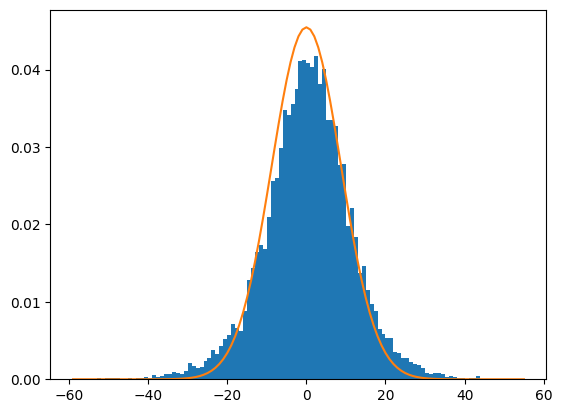

In [57]:
from scipy.stats import skellam
import numpy as np

precision = 1e-2

vals = ((z_val - z_marginal_mu_val) / precision).round().int().view(-1).cpu().numpy()

skellam_mu = ((z_marginal_std_val.mean() / precision)**2) / 2
x_vals = np.arange(vals.min(), vals.max() + 1)
pmf = np.exp(skellam.logpmf(x_vals, skellam_mu, skellam_mu))

plt.hist(vals, bins=range(vals.min(), vals.max() + 1), density=True)
plt.plot(x_vals, pmf)
plt.show()